# Intrinsic Evaluation
Firstly, we will load the *OHSUMED* data from different files and merge them into one combined dataframe, containing all years from 1987 - 1991. Afterwards, we will load the file where the relevance labels of documents during all five years will be labeled. In the end, we will left join the relevance labels to our main dataframe.

This data was not given by the paper and we had to search for it ourselves which was quite challenging.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def parse_ohsumed_file(file_path):
    """Parses an OHSUMED file into a DataFrame with proper column names."""
    documents = []
    document = {}

    # Read the file line by line
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Remove extra whitespace

            if line.startswith(".I"):  # New document identifier
                if document:  # If there's an existing document, save it
                    documents.append(document)
                document = {"sequential identifier": line[3:]}  # Initialize a new document

            elif line.startswith(".U"):  # MEDLINE identifier
                document["MEDLINE identifier"] = next(f).strip()

            elif line.startswith(".S"):  # Source
                document["source"] = next(f).strip()

            elif line.startswith(".M"):  # MeSH terms
                document["mesh_terms"] = next(f).strip()

            elif line.startswith(".T"):  # Title
                document["title"] = next(f).strip()

            elif line.startswith(".P"):  # Publication type
                document["publication type"] = next(f).strip()

            elif line.startswith(".W"):  # Abstract
                document["abstract"] = next(f).strip()

            elif line.startswith(".A"):  # Author
                document["author"] = next(f).strip()

    # Add the last document if it exists
    if document:
        documents.append(document)

    # Convert the list of documents into a DataFrame
    return pd.DataFrame(documents)

# File paths for individual files
file_87_path = "data/ohsumed.87.txt"
file_88_path = "data/ohsumed.88.txt"
file_89_path = "data/ohsumed.89.txt"
file_90_path = "data/ohsumed.90.txt"
file_91_path = "data/ohsumed.91.txt"

# Parse each file into its own DataFrame
df_ohsumed_87 = parse_ohsumed_file(file_87_path)
df_ohsumed_88 = parse_ohsumed_file(file_88_path)
df_ohsumed_89 = parse_ohsumed_file(file_89_path)
df_ohsumed_90 = parse_ohsumed_file(file_90_path)
df_ohsumed_91 = parse_ohsumed_file(file_91_path)

In [6]:
# Checking row amount of all years files
print(f"Number of rows in ohsumed.87: {len(df_ohsumed_87)}")
print(f"Number of rows in ohsumed.88: {len(df_ohsumed_88)}")
print(f"Number of rows in ohsumed.89: {len(df_ohsumed_89)}")
print(f"Number of rows in ohsumed.90: {len(df_ohsumed_90)}")
print(f"Number of rows in ohsumed.91: {len(df_ohsumed_91)}")

Number of rows in ohsumed.87: 54710
Number of rows in ohsumed.88: 70825
Number of rows in ohsumed.89: 74869
Number of rows in ohsumed.90: 73824
Number of rows in ohsumed.91: 74338


In [7]:
# Combine all DataFrames into a single DataFrame
ohsumed_combined_df = pd.concat([df_ohsumed_87, df_ohsumed_88, df_ohsumed_89, df_ohsumed_90, df_ohsumed_91], ignore_index=True)

# Print the combined DataFrame's shape (rows and columns). Should be: 348566
print(f"Combined DataFrame shape: {ohsumed_combined_df.shape}")

# Display the first few rows of the combined DataFrame
print(ohsumed_combined_df.head())

Combined DataFrame shape: (348566, 8)
  sequential identifier MEDLINE identifier                             source  \
0                     1           87049087    Am J Emerg Med 8703; 4(6):491-5   
1                     2           87049088  Am J Emerg Med 8703; 4(6):496-500   
2                     3           87049089    Am J Emerg Med 8703; 4(6):501-3   
3                     4           87049090    Am J Emerg Med 8703; 4(6):504-6   
4                     5           87049092    Am J Emerg Med 8703; 4(6):511-3   

                                          mesh_terms  \
0  Allied Health Personnel/*; Electric Countersho...   
1  Antidepressive Agents, Tricyclic/*PO; Arrhythm...   
2  Adult; Aircraft/*; Altitude/*; Blood Gas Monit...   
3  Adolescence; Adult; Aged; Blood Glucose/*ME; D...   
4  Aged; Aged, 80 and over; Case Report; Female; ...   

                                               title  publication type  \
0  Refibrillation managed by EMT-Ds: incidence an...  JOURNAL AR

to get the right relevance labels, we had to search for the "judged.txt". This was also quite hard and required an intensive online-search

In [8]:
# Load the judged file (relevance labeles)
judged_df = pd.read_csv("./data/judged.txt", sep="\t", header=None,
                        names=["Query", "Document-UI", "Document-Index", "Relevance1", "Relevance2", "Relevance3"])

print(f"Loaded judged file with {len(judged_df)} rows")
judged_df.head()

# Get unique documents
unique_docs = judged_df['Document-UI'].nunique()
judged_df = judged_df.drop_duplicates(subset=['Document-UI'], keep='first')

# We keep only unique documents
print(f"Unique documents: {unique_docs}")
print(f"New df size: {len(judged_df)}")

judged_df.head()

Loaded judged file with 16140 rows
Unique documents: 14430
New df size: 14430


,Query,Document-UI,Document-Index,Relevance1,Relevance2,Relevance3
0,1,87097544,40626,d,NaN,d
1,1,87153566,11852,n,NaN,n
2,1,87157536,12693,d,NaN,NaN
3,1,87157537,12694,d,NaN,NaN
4,1,87184723,15450,n,NaN,NaN


In [9]:
judged_df.rename(columns={"Document-UI": "MEDLINE identifier"}, inplace=True)

# Converting key to string
ohsumed_combined_df["MEDLINE identifier"] = ohsumed_combined_df["MEDLINE identifier"].astype(int)
judged_df["MEDLINE identifier"] = judged_df["MEDLINE identifier"].astype(int)
judged_df["is_relevant_ind"] = 1

# Perform the left join
merged_df = ohsumed_combined_df.merge(judged_df, on="MEDLINE identifier", how="left")

# Display the resulting DataFrame
print(f"Resulting DataFrame shape: {merged_df.shape}")
print(merged_df.head())

# Create a new column Relevance_total based on the rules that can be kept showing relevance for all three relevance columns
merged_df["Relevance_total"] = np.where(
    ~merged_df["Relevance1"].isna(),  # If Relevance1 is not NaN, take it
    merged_df["Relevance1"],
    np.where(
        ~merged_df["Relevance2"].isna(),  # Else if Relevance2 is not NaN, take it
        merged_df["Relevance2"],
        merged_df["Relevance3"]  # Else take Relevance3
    )
)
merged_df.head(10000)

# Drop the specified columns
columns_to_drop = ["Query", "Document-Index", "Relevance1", "Relevance2", "Relevance3"]
merged_df.drop(columns=columns_to_drop, inplace=True)
# Mapping relevance labels to int
relevance_mapping = {'n': 0, 'p': 1, 'd': 2}

# Filling mising values in abstract so that BERT can be trained on strings
merged_df["abstract"] = merged_df["abstract"].fillna("")

# Apply the mapping to the Relevance1 column
merged_df["Relevance_total"] = merged_df["Relevance_total"].map(relevance_mapping)

# Display the resulting DataFrame
print(f"Resulting DataFrame shape: {merged_df.shape}")
print(merged_df.head())

#filtered_df = merged_df[merged_df["Relevance1"].notna()]
#
## Display the filtered DataFrame
#print(f"Number of rows where Relevance1 is not NaN: {len(filtered_df)}")
#print(filtered_df.head())

Resulting DataFrame shape: (348566, 14)
  sequential identifier  MEDLINE identifier  \
0                     1            87049087   
1                     2            87049088   
2                     3            87049089   
3                     4            87049090   
4                     5            87049092   

                              source  \
0    Am J Emerg Med 8703; 4(6):491-5   
1  Am J Emerg Med 8703; 4(6):496-500   
2    Am J Emerg Med 8703; 4(6):501-3   
3    Am J Emerg Med 8703; 4(6):504-6   
4    Am J Emerg Med 8703; 4(6):511-3   

                                          mesh_terms  \
0  Allied Health Personnel/*; Electric Countersho...   
1  Antidepressive Agents, Tricyclic/*PO; Arrhythm...   
2  Adult; Aircraft/*; Altitude/*; Blood Gas Monit...   
3  Adolescence; Adult; Aged; Blood Glucose/*ME; D...   
4  Aged; Aged, 80 and over; Case Report; Female; ...   

                                               title  publication type  \
0  Refibrillation managed

In [10]:
#Checking how many relevant documents are present in merged DF. Expectation: 16140
count_is_relevant = merged_df[merged_df["is_relevant_ind"] == 1].shape[0]
print(f"Number of rows where is_relevant_ind = 1: {count_is_relevant}")

Number of rows where is_relevant_ind = 1: 14430


Now, we have a merged dataframe, containing all document data and also the relevance labeling of the documents. Now we can proceed with splitting the data.

In [11]:
test = merged_df[merged_df["is_relevant_ind"] == 1]
remaining_rows = merged_df[merged_df["is_relevant_ind"] != 1]
training, validation = train_test_split(remaining_rows, test_size=0.15, random_state=42)

print(f"Test set size: {len(test)}")
print(f"Training set size: {len(training)}")
print(f"Validation set size: {len(validation)}")

Test set size: 14430
Training set size: 284015
Validation set size: 50121


Training LR

In [12]:
training.loc[:, 'title_abstract'] = training['title'] + ' ' + training['abstract']
test.loc[:, 'title_abstract'] = test['title'] + ' ' + test['abstract']
validation.loc[:, 'title_abstract'] = validation['title'] + ' ' + validation['abstract']
training.head()
test.head()
validation.head()

/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_8476/4000273643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'title_abstract'] = test['title'] + ' ' + test['abstract']


,sequential identifier,MEDLINE identifier,source,mesh_terms,title,publication type,abstract,author,is_relevant_ind,Relevance_total,title_abstract
33697,33698,87124329,Am Heart J 8705; 113(2 Pt 1):273-9,Aged; Comparative Study; Electrocardiography/*...,Non-Q wave myocardial infarction: recent chang...,JOURNAL ARTICLE.,A community-wide study of patients hospitalize...,Goldberg RJ; Gore JM; Alpert JS; Dalen JE.,NaN,NaN,Non-Q wave myocardial infarction: recent chang...
245340,245341,90357619,Transplant Proc 9011; 22(4):1885-6,"Antibodies, Anti-Idiotypic/*IM; Antibodies, Mo...",IgM-anti-IgG antibody as cause of positive B-c...,JOURNAL ARTICLE.,,Terness P; Berteli AJ; Steinitz M; Mytillineos...,NaN,NaN,IgM-anti-IgG antibody as cause of positive B-c...
306208,306209,91170056,J Appl Physiol 9106; 69(6):2091-6,Animal; Blood Pressure; Cardiac Output; Hemody...,Altered baroreflex function after tail suspens...,JOURNAL ARTICLE.,Experiments were performed on conscious chroni...,Brizzee BL; Walker BR.,NaN,NaN,Altered baroreflex function after tail suspens...
5057,5058,87097540,Am J Obstet Gynecol 8704; 156(1):52-6,Apgar Score; Cesarean Section/*; Delivery/*MT;...,Randomized management of the second nonvertex ...,JOURNAL ARTICLE.,Sixty twin deliveries after the thirty-fifth g...,Rabinovici J; Barkai G; Reichman B; Serr DM; M...,NaN,NaN,Randomized management of the second nonvertex ...
120427,120428,88110706,Chest 8805; 93(2):294-8,Adult; Aged; Arteries/*; Bloodletting/*; Carbo...,Single arterial puncture vs arterial cannula f...,JOURNAL ARTICLE.,"In an attempt to find the least invasive, safe...",Frye M; DiBenedetto R; Lain D; Morgan K.,NaN,NaN,Single arterial puncture vs arterial cannula f...


to assign the right "ground truth" labels, we have to find the correct mesh terms and parse our files to find sensitive content. The Terms can be found in mtrees2019.bin

In [13]:
import pandas as pd
import re

# Step 1: Parse the .bin file to extract sensitive MeSH terms
def parse_mesh_bin(file_path, target_categories):
    """
    Extract MeSH terms under specific categories from a .bin file.

    Args:
        file_path (str): Path to the .bin file.
        target_categories (list): List of categories (e.g., ["C12", "C13"]).

    Returns:
        list: List of MeSH terms under the target categories.
    """
    mesh_terms = []
    with open(file_path, "r") as f:
        for line in f:
            # Split by ';' to separate terms and categories
            parts = line.strip().split(";")
            if len(parts) > 1:
                term, category = parts[0].strip().lower(), parts[1].strip()
                # Include terms under target categories
                if any(category.startswith(target) for target in target_categories):
                    mesh_terms.append(term)
    return mesh_terms

# Path to the .bin file
file_path = "data/mtrees2019.bin"

# Extract MeSH terms under C12 and C13
sensitive_terms = parse_mesh_bin(file_path, ["C12", "C13"])

# Step 2: Preprocessing function for the `mesh_terms` column
def preprocess_mesh_terms(mesh_terms):
    """
    Normalize and preprocess the MeSH terms in a document.

    Args:
        mesh_terms (str): The raw MeSH terms for a document.

    Returns:
        list: A list of cleaned MeSH terms.
    """
    if isinstance(mesh_terms, str):
        terms = mesh_terms.split(";")
        return [re.sub(r"/.*", "", term).strip().lower() for term in terms]
    return []

# Step 3: Define the matching function using sensitive terms
sensitive_pattern = re.compile(r"\b(" + "|".join(re.escape(term) for term in sensitive_terms) + r")\b", re.IGNORECASE)

def is_sensitive_regex(terms):
    """
    Check if any term in the document is sensitive based on MeSH terms.

    Args:
        terms (list of str): Processed MeSH terms.

    Returns:
        int: 1 if sensitive, 0 otherwise.
    """
    return 1 if any(sensitive_pattern.search(term) for term in terms) else 0

# Step 4: Apply preprocessing and matching to datasets
for df in [training, validation, test]:
    df.loc[:, "processed_mesh_terms"] = df["mesh_terms"].apply(preprocess_mesh_terms)
    df.loc[:, "sensitive"] = df["processed_mesh_terms"].apply(is_sensitive_regex)
    df.loc[:, "label"] = df["sensitive"]

# Step 5: Calculate sensitive document percentages
datasets = [
    (pd.concat([training, validation, test]), "Full dataset"),
    (test, "Judged documents")
]

for df, name in datasets:
    percentage = df["label"].mean() * 100
    print(f"{name}: {percentage:.1f}%")

for df in [training, validation, test]:
    df.drop(columns=["sensitive"], inplace=True)

/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_8476/453884967.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "processed_mesh_terms"] = df["mesh_terms"].apply(preprocess_mesh_terms)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_8476/453884967.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "sensitive"] = df["processed_mesh_terms"].apply(is_sensitive_regex)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_8476/453884967.py:69: SettingWithCopyWa

Full dataset: 8.1%
Judged documents: 12.3%


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_8476/453884967.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["sensitive"], inplace=True)


In [14]:
for df, name in [(training, "Training"), (validation, "Validation"), (test, "Test")]:
    sensitive_docs = df[df["label"] == 1]
    total_docs = len(df)
    relative_percentage = (len(sensitive_docs) / total_docs) * 100

    print(f"Sensitive documents in {name}:")
    print(sensitive_docs[["mesh_terms", "processed_mesh_terms", "label"]].head())
    print(f"Total sensitive documents in {name}: {len(sensitive_docs)}")
    print(f"Relative amount of sensitive documents in {name}: {relative_percentage:.1f}%\n")

Sensitive documents in Training:
                                               mesh_terms  \
54170   Adult; Cardiovascular Diseases/ET/*MO; Diabete...   
3827    Antigens, Bacterial/*AN; Chlamydia trachomatis...   
63723   Adult; Evaluation Studies; Female; Hospitals, ...   
144305  Adult; Antineoplastic Agents, Combined/*TU; Ca...   
160573  Acidosis, Renal Tubular/*CO/ET; Adult; Case Re...   

                                     processed_mesh_terms  label  
54170   [adult, cardiovascular diseases, diabetes mell...      1  
3827    [antigens, bacterial, chlamydia trachomatis, c...      1  
63723   [adult, evaluation studies, female, hospitals,...      1  
144305  [adult, antineoplastic agents, combined, case ...      1  
160573  [acidosis, renal tubular, adult, case report, ...      1  
Total sensitive documents in Training: 22371
Relative amount of sensitive documents in Training: 7.9%

Sensitive documents in Validation:
                                               mesh_terms  \

Grid search 5 fold cross validation for the tokenization in logistic regression.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Pipeline creation
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words='english')),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# Grid definition
param_grid = {
    "vectorizer__max_features": [1000, 3000, 5000, 10000, None],  # Maximum number of features
    "vectorizer__ngram_range": [(1, 1), (1, 2)],  # Unigrams or unigrams + bigrams
}

# Grid Search with 5-cv
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

# Division in features and response
X_train, y_train = training["title_abstract"], training["label"]
X_test, y_test = test["title_abstract"], test["label"]
X_validation, y_validation = validation["title_abstract"], validation["label"]

# Training and search for best parameters
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best tokenization parameters: {grid_search.best_params_}")

Logistic regression without setting the threeshold

In [14]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Creation of the optimal vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',  max_features=list(grid_search.best_params_.values())[0], ngram_range=list(grid_search.best_params_.values())[1]
)

# Applying vectorization to dataset
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_validation = vectorizer.transform(X_validation)

# Training the model with the best parameters
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Sensitive', 'Sensitive'],
            yticklabels=['Not Sensitive', 'Sensitive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") # sensitivity
print(f"F1-score: {f1:.4f}")
print(f"F2-score: {f2:.4f}")

KeyboardInterrupt: 

Optimizing the threshold

In [25]:
# Grid search
thresholds = np.arange(0, 1, 0.01)
best_f1, best_threshold = 0, 0
for t in thresholds:
    y_pred_threshold = (model.predict_proba(X_validation)[:, 1] >= t).astype(int)
    score = f1_score(y_validation, y_pred_threshold)
    if score > best_f1:
        best_f1, best_threshold = score, t

print(f"Best F1: {best_f1:.4f} at threshold {best_threshold}")

Best F1: 0.7382 at threshold 0.66


Applying the best threshold to the original model

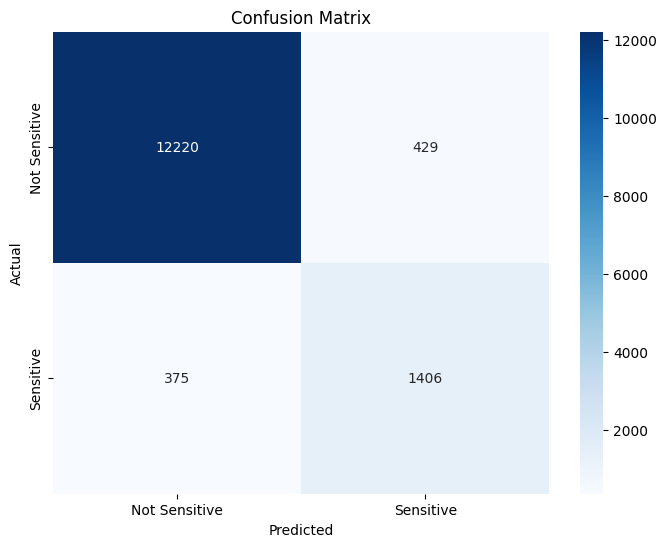

Accuracy: 0.9443
Precision: 0.7662
Recall: 0.7894
F1-score: 0.7777
F2-score: 0.7847


In [26]:
# New threshold
y_pred_test = (model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

# Evaluation
cm2 = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Sensitive', 'Sensitive'],
            yticklabels=['Not Sensitive', 'Sensitive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy_2 = accuracy_score(y_test, y_pred_test)
precision_2 = precision_score(y_test, y_pred_test)
recall_2 = recall_score(y_test, y_pred_test)
f1_2 = f1_score(y_test, y_pred_test)
f2_2 = fbeta_score(y_test, y_pred_test, beta=2)


print(f"Accuracy: {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}") # sensitivity
print(f"F1-score: {f1_2:.4f}")
print(f"F2-score: {f2_2:.4f}")

# Statistical Significance

- results from the paper: 
- Accuracy: 94.01
- Precision: 76.72
- Recall: 73.29
- F1: 74.96
- F2: 73.95



- our results:
- Accuracy: 94.43
- Precision: 76.62
- Recall: 78.94
- F1: 77.77
- F2: 78.47

In [28]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# Convert labels to NumPy array
y_train_array = np.array(y_train)

# Create vectorizer
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=list(grid_search.best_params_.values())[0],
    ngram_range=list(grid_search.best_params_.values())[1]
)

# Vectorize dataset
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# **Step 1: Train Model on Full Training Set**
model = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
model.fit(X_train_vec, y_train_array)

# **Step 2: Find the Best Threshold Globally**
y_train_probs = model.predict_proba(X_train_vec)[:, 1]  # Get probabilities for the full training set

# Search for the best threshold using the entire training set
thresholds = np.arange(0, 1, 0.01)
best_f1, best_threshold = 0, 0
for t in thresholds:
    y_pred_threshold = (y_train_probs >= t).astype(int)
    score = f1_score(y_train_array, y_pred_threshold)
    if score > best_f1:
        best_f1, best_threshold = score, t

print(f"🔹 Best Global Threshold: {best_threshold:.2f} (Optimized on Full Training Set)")

# **Step 3: Apply This One Threshold in Cross-Validation**
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store performance metrics
accuracy_scores, precision_scores, recall_scores, f1_scores, f2_scores = [], [], [], [], []

for train_idx, val_idx in cv.split(X_train_vec, y_train_array):
    X_train_fold, X_val_fold = X_train_vec[train_idx], X_train_vec[val_idx]
    y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]

    # **Train model in each fold**
    model.fit(X_train_fold, y_train_fold)

    # Get predicted probabilities
    y_val_probs = model.predict_proba(X_val_fold)[:, 1]

    # **Apply the globally optimized threshold**
    y_pred_final = (y_val_probs >= best_threshold).astype(int)

    # Compute performance metrics
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_final))
    precision_scores.append(precision_score(y_val_fold, y_pred_final))
    recall_scores.append(recall_score(y_val_fold, y_pred_final))
    f1_scores.append(f1_score(y_val_fold, y_pred_final))
    f2_scores.append(fbeta_score(y_val_fold, y_pred_final, beta=2))

# Convert results to numpy arrays
accuracy_scores = np.array(accuracy_scores)
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
f1_scores = np.array(f1_scores)
f2_scores = np.array(f2_scores)

# Print mean and standard deviation
print(f"Mean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
print(f"Mean Precision: {precision_scores.mean():.4f} ± {precision_scores.std():.4f}")
print(f"Mean Recall: {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
print(f"Mean F1-score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
print(f"Mean F2-score: {f2_scores.mean():.4f} ± {f2_scores.std():.4f}")


🔹 Best Global Threshold: 0.63 (Optimized on Full Training Set)
Mean Accuracy: 0.9571 ± 0.0012
Mean Precision: 0.7138 ± 0.0078
Mean Recall: 0.7597 ± 0.0117
Mean F1-score: 0.7360 ± 0.0081
Mean F2-score: 0.7501 ± 0.0099


In [40]:
from scipy.stats import norm
import numpy as np

# Confidence level (95%)
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # 1.96 for 95% CI

# Number of folds
n_folds = 5

# Paper-reported means (replace with actual values)
paper_means = {
    "accuracy": 0.9401,
    "precision": 0.7672,
    "recall": 0.7329,
    "f1_score": 0.7496,
    "f2_score": 0.7395
}

# Our cross-validation results
our_means = {
    "accuracy": 0.9571,
    "precision": 0.7138 ,
    "recall": 0.7597,
    "f1_score": 0.7360,
    "f2_score": 0.7501
}

our_std_devs = {
    "accuracy": 0.0012,
    "precision": 0.0078,
    "recall": 0.0117,
    "f1_score": 0.0081,
    "f2_score": 0.0099
}

# Function to compute 95% confidence interval
def compute_ci(mean, std, n, z=z_score):
    margin_of_error = z * (std / np.sqrt(n))
    return mean - margin_of_error, mean + margin_of_error

# Compute and compare confidence intervals
print("\n**Confidence Interval Analysis**")
for metric in paper_means.keys():
    our_lower, our_upper = compute_ci(our_means[metric], our_std_devs[metric], n_folds)
    paper_value = paper_means[metric]

    print(f"{metric}:")
    print(f"  Our model's 95% CI: [{our_lower:.4f}, {our_upper:.4f}]")
    print(f"  Paper's reported mean: {paper_value:.4f}")

    # Check if the paper's mean falls within our confidence interval
    if our_lower <= paper_value <= our_upper:
        print("  🟢 No significant difference (paper's mean is within our CI)\n")
    else:
        print("  🔴 Statistically significant difference (paper's mean is outside our CI)\n")



**Confidence Interval Analysis**
accuracy:
  Our model's 95% CI: [0.9560, 0.9582]
  Paper's reported mean: 0.9401
  🔴 Statistically significant difference (paper's mean is outside our CI)

precision:
  Our model's 95% CI: [0.7070, 0.7206]
  Paper's reported mean: 0.7672
  🔴 Statistically significant difference (paper's mean is outside our CI)

recall:
  Our model's 95% CI: [0.7494, 0.7700]
  Paper's reported mean: 0.7329
  🔴 Statistically significant difference (paper's mean is outside our CI)

f1_score:
  Our model's 95% CI: [0.7289, 0.7431]
  Paper's reported mean: 0.7496
  🔴 Statistically significant difference (paper's mean is outside our CI)

f2_score:
  Our model's 95% CI: [0.7414, 0.7588]
  Paper's reported mean: 0.7395
  🔴 Statistically significant difference (paper's mean is outside our CI)

